## 1. Load Data

In [1]:
import pandas as pd

# Variants
train_variants = pd.read_csv("training_variants")
val_variants = pd.read_csv("stage2_test_variants.csv")

# Load the data from file
train_text = pd.read_csv("training_text", 
                         sep="\|\|", 
                         header=None, 
                         skiprows=1, 
                         names=["ID","Text"],
                         engine="python"
                        )

val_text = pd.read_csv("stage2_test_text.csv", 
                       sep="\|\|", 
                       header=None, 
                       skiprows=1, 
                       names=["ID","Text"],
                       engine="python"
                      )

print(train_variants.shape)
print(val_variants.shape)
print(train_text.shape)
print(val_text.shape)

(3321, 4)
(986, 3)
(3321, 2)
(986, 2)


In [2]:
# Use inner join to merge the datasets on ID
train = pd.merge(left=train_variants, right=train_text, how="inner", on="ID").fillna('')
val = pd.merge(left=val_variants, right=val_text, how="inner", on="ID").fillna('')

print(train.shape)
print(val.shape)

(3321, 5)
(986, 4)


In [3]:
# Separate the target attribute
train_y = train['Class'].values
train_x = train.drop('Class', axis=1)

print(train_y.shape)
print(train_x.shape)

(3321,)
(3321, 4)


In [6]:
import numpy as np

# Get the index values of the training data
train_index = train_x['ID'].values

# Create one master dataset that contains the train and validation text
all_data = np.concatenate((train_x, val), axis=0)
all_data = pd.DataFrame(all_data)
all_data.columns = ["ID", "Gene", "Variation", "Text"]

print(all_data.shape)

(4307, 4)


In [7]:
all_data.head(10)

,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...
5,5,CBL,V391I,Oncogenic mutations in the monomeric Casitas B...
6,6,CBL,V430M,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL,Deletion,CBL is a negative regulator of activated recep...
8,8,CBL,Y371H,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,CBL,C384R,Abstract Juvenile myelomonocytic leukemia (JM...


## 2. Preprocessing

In [12]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Initialize a stemmer
stemmer = PorterStemmer()

# Function that turns a doc into clean tokens
def clean_doc(text):
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table).lower() for w in tokens]
    tokens = [w for w in tokens if w.isalpha()]
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if len(w) > 1]
    tokens = [stemmer.stem(w) for w in tokens]
    tokens = " ".join(tokens)
    return(tokens)

# Clean the text
allText = all_data['Text'].apply(clean_doc)
allText.head()

0    cyclindepend kinas cdk regul varieti fundament...
1    abstract background nonsmal cell lung cancer n...
2    abstract background nonsmal cell lung cancer n...
3    recent evid demonstr acquir uniparent disomi a...
4    oncogen mutat monomer casita blineag lymphoma ...
Name: Text, dtype: object

In [13]:
from gensim.models.doc2vec import LabeledSentence
from gensim import utils

# Function to create labeled sentences
def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return (sentences)

sentences = constructLabeledSentences(allText)
sentences[0]

LabeledSentence(words=['cyclindepend', 'kinas', 'cdk', 'regul', 'varieti', 'fundament', 'cellular', 'process', 'stand', 'one', 'last', 'orphan', 'cdk', 'activ', 'cyclin', 'identifi', 'kinas', 'activ', 'reveal', 'previou', 'work', 'shown', 'silenc', 'increas', 'vet', 'erythroblastosi', 'viru', 'oncogen', 'homolog', 'activ', 'mapk', 'pathway', 'confer', 'tamoxifen', 'resist', 'breast', 'cancer', 'cell', 'precis', 'mechan', 'modul', 'activ', 'gener', 'function', 'remain', 'elus', 'demonstr', 'cyclindepend', 'kinas', 'identifi', 'cyclin', 'activ', 'cyclin', 'cyclin', 'orphan', 'cyclin', 'product', 'whose', 'mutat', 'caus', 'star', 'syndrom', 'human', 'development', 'anomali', 'whose', 'featur', 'includ', 'toe', 'syndactyli', 'telecanthu', 'anogenit', 'renal', 'malform', 'show', 'star', 'syndromeassoci', 'cyclin', 'mutant', 'unabl', 'interact', 'cyclin', 'silenc', 'phenocopi', 'silenc', 'increas', 'craf', 'confer', 'tamoxifen', 'resist', 'breast', 'cancer', 'cell', 'phosphoryl', 'vitro', 'c

## 3. Text Featurizer using Doc2Vec

In [14]:
from gensim.models import Doc2Vec

# Size of the document vector to create
INPUT_DIM = 300

# Train the Doc2Vec model
text_model = Doc2Vec(min_count=1, window=5, size=INPUT_DIM, sample=1e-4, negative=5, workers=4, iter=5, seed=1)
text_model.build_vocab(sentences)
text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
text_model.save('docEmbeddings.d2v')

In [15]:
train_size = len(train_x)
val_size = len(val)

# Initialize empty numpy arrays
text_train_arrays = np.zeros((train_size, INPUT_DIM))
text_val_arrays = np.zeros((val_size, INPUT_DIM))

# Featurize text for training data
for i in range(train_size):
    text_train_arrays[i] = text_model.docvecs['Text_'+ str(i)]

# Featurize text for test data
j=0
for i in range(train_size, train_size + val_size):
    text_val_arrays[j] = text_model.docvecs['Text_'+ str(i)]
    j = j + 1

print(text_train_arrays.shape)
print(text_val_arrays.shape)
print(text_train_arrays[0][:50])

(3321, 300)
(986, 300)
[ 0.32290092  0.43051752 -0.21540494 -0.0119901   0.19986451 -0.47126719
 -0.47583261  0.11471524  1.06948566 -0.38218367  0.30670464  0.26544219
 -0.25053924  0.432408   -0.12824671  0.16619502  0.01633745 -0.80925381
  0.27576631  0.14460726  0.40435719 -0.2367079   0.35924739  0.1004831
  0.08701938  0.59063238  0.11825053 -0.33110484  1.12264061 -0.39379859
 -0.4281714  -0.54881704  0.33253103 -0.34457126  0.5662176   0.28578684
  0.59600967  0.044645   -0.03634984 -0.41822398 -0.09343986  0.10681896
 -0.38827273  0.04062575 -0.19135647  0.11403963  0.89286596 -0.11179078
  0.3566052   0.32833025]


In [16]:
from sklearn.decomposition import TruncatedSVD

GENE_DIM = 25

svd = TruncatedSVD(n_components=25, n_iter=GENE_DIM, random_state=1986)

# Gene featurizer
one_hot_gene = pd.get_dummies(all_data['Gene'])
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)
print(truncated_one_hot_gene.shape)

# Variation featurizer
one_hot_variation = pd.get_dummies(all_data['Variation'])
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)
print(truncated_one_hot_variation.shape)

(4307, 25)
(4307, 25)


In [17]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

# Output class encoding
label_encoder = LabelEncoder()
label_encoder.fit(train_y)
encoded_y = np_utils.to_categorical((label_encoder.transform(train_y)))
print(encoded_y.shape)
print(encoded_y[0])

Using TensorFlow backend.


(3321, 9)
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [18]:
# Create the final training dataset by merging the genes, variations, and text
train_set = np.hstack((truncated_one_hot_gene[:train_size], 
                       truncated_one_hot_variation[:train_size],
                       text_train_arrays
                      ))

# Create the final validation dataset by merging the genes, variations, and text
val_set = np.hstack((truncated_one_hot_gene[train_size:],
                     truncated_one_hot_variation[train_size:],
                     text_val_arrays
                    ))

print(train_set.shape)
print(val_set.shape)

(3321, 350)
(986, 350)


## 4. Keras Baseline Model

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

# Split the dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(train_set, encoded_y, test_size=0.1, random_state=20171104)
train_actual_y, test_actual_y = train_test_split(train_y, test_size=0.1, random_state=20171104)

input_dim = INPUT_DIM + (GENE_DIM * 2)

def baseline_model():
    model = Sequential()
    model.add(Dense(40, input_dim=input_dim, activation='sigmoid'))
    model.add(Dropout(0.3))
    model.add(Dense(9, activation="softmax")) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return (model)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, verbose=True)

# Checkpoint - used to get the best weights during the model training process
checkpoint = ModelCheckpoint(filepath='baseline_weights.h5', monitor='val_acc', save_best_only=True)

# Initialize the model
model = baseline_model()
model.summary()

# Fit the model
model.fit(x_train, 
          y_train, 
          validation_data=(x_test, y_test), 
          epochs=50, 
          batch_size=64, 
          callbacks=[early_stopping, checkpoint], 
          verbose=2
         )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 40)                14040     
_________________________________________________________________
dropout_13 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 9)                 369       
Total params: 14,409
Trainable params: 14,409
Non-trainable params: 0
_________________________________________________________________
Train on 2988 samples, validate on 333 samples
Epoch 1/50
 - 0s - loss: 2.0588 - acc: 0.2205 - val_loss: 1.8049 - val_acc: 0.3544
Epoch 2/50
 - 0s - loss: 1.7676 - acc: 0.3588 - val_loss: 1.6939 - val_acc: 0.3904
Epoch 3/50
 - 0s - loss: 1.6505 - acc: 0.4170 - val_loss: 1.6168 - val_acc: 0.4084
Epoch 4/50
 - 0s - loss: 1.5928 - acc: 0.4237 - val_loss: 1.5589 - val_acc: 0.4144
Epoch 5/50
 - 0s - loss

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


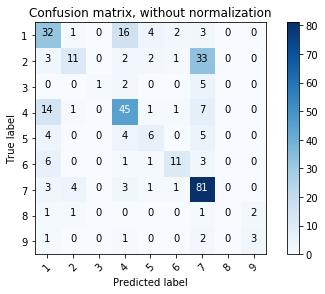

In [28]:
from keras.models import load_model

# Load the best iteration
model = load_model('baseline_weights.h5')

# Make the predictions
preds = model.predict_classes(x_test)
preds = [i + 1 for i in preds]

# Create the confusion matrix
cm = confusion_matrix(test_actual_y, preds, labels=[1,2,3,4,5,6,7,8,9])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[1,2,3,4,5,6,7,8,9], title='Confusion matrix, without normalization')
plt.show()

In [29]:
# Calculate accuracy
acc = np.sum(np.diag(cm)) / np.sum(cm)
print('Accuracy: %0.5f' % acc)
print(model.evaluate(x_test, y_test))

Accuracy: 0.57057
333/333 [==============================] - 0s 186us/step
[1.2071925643328074, 0.57057057146553525]


In [56]:
# Make predictions for submission
preds1 = model.predict_proba(val_set)

submission = pd.DataFrame(preds1)
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9']
submission.to_csv("baseline_submission.csv", index=True)
submission.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,0.167579,0.020295,0.025743,0.141886,0.130041,0.499483,0.013252,0.001082,0.000639
1,0.918117,0.002006,0.001491,0.062015,0.007225,0.003653,0.004556,0.000445,0.000492
2,0.096299,0.214556,0.008106,0.030617,0.016624,0.296389,0.328949,0.004852,0.003609
3,0.166503,0.383831,0.003820,0.025326,0.011831,0.064429,0.302084,0.019295,0.022881
4,0.004108,0.153226,0.007314,0.012798,0.016365,0.008664,0.792487,0.002315,0.002723


## 5. Keras LTSM Model

In [47]:
from keras.preprocessing.text import Tokenizer

# Use the Keras tokenizer
num_words = 5000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(allText)

In [48]:
from keras.preprocessing.sequence import pad_sequences

# Pad the data 
pad_x = tokenizer.texts_to_sequences(allText)
pad_x = pad_sequences(pad_x, maxlen=num_words)
print(pad_x.shape)

(4307, 5000)


In [49]:
# Split the dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(pad_x[:train_size,:], encoded_y, test_size=0.1, random_state=20171104)
print(x_train.shape)

embed_dim = 128
lstm_out = 196

# Build simple LTSM model
def ltsm_model():
    model = Sequential()
    model.add(Embedding(num_words, embed_dim, input_length=x_train.shape[1]))
    model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return (model)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, verbose=True)

# Checkpoint - used to get the best weights during the model training process
checkpoint = ModelCheckpoint(filepath='lstm_weights.h5', monitor='val_acc', save_best_only=True)

# Initialize the model
model = ltsm_model()
model.summary()

# Fit the model
model.fit(x_train, 
          y_train, 
          validation_data=(x_test, y_test), 
          epochs=20, 
          batch_size=64, 
          callbacks=[early_stopping, checkpoint], 
          verbose=2
         )

(2988, 5000)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 5000, 128)         640000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_28 (Dense)             (None, 9)                 1773      
Total params: 896,573
Trainable params: 896,573
Non-trainable params: 0
_________________________________________________________________
Train on 2988 samples, validate on 333 samples
Epoch 1/20
 - 439s - loss: 1.8882 - acc: 0.2845 - val_loss: 1.7679 - val_acc: 0.3063
Epoch 2/20
 - 437s - loss: 1.4954 - acc: 0.4736 - val_loss: 1.4353 - val_acc: 0.4655
Epoch 3/20
 - 436s - loss: 1.1572 - acc: 0.5877 - val_loss: 1.2819 - val_acc: 0.5285
Epoch 4/20
 - 435s - loss: 0.9515 - acc: 0.6556 - val_loss: 1.2168 - val_acc: 0.5616


Confusion matrix, without normalization


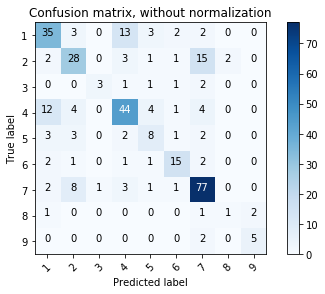

Accuracy: 0.64865
333/333 [==============================] - 17s 52ms/step
[1.2740439094222702, 0.64864864954361323]


In [50]:
# Load the best iteration
model = load_model('lstm_weights.h5')

# Make the predictions
preds = model.predict_classes(x_test)
preds = [i + 1 for i in preds]

# Create the confusion matrix
cm = confusion_matrix(test_actual_y, preds, labels=[1,2,3,4,5,6,7,8,9])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[1,2,3,4,5,6,7,8,9], title='Confusion matrix, without normalization')
plt.show()

# Calculate accuracy
acc = np.sum(np.diag(cm)) / np.sum(cm)
print('Accuracy: %0.5f' % acc)
print(model.evaluate(x_test, y_test))

In [55]:
# Make predictions for submission
preds2 = model.predict_proba(pad_x[train_size:,:])

submission = pd.DataFrame(preds2)
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9']
submission.to_csv("lstm_submission.csv", index=True)
submission.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,0.025327,0.000131,0.001071,0.969386,0.000434,0.000435,0.003114,0.000084,0.000019
1,0.012817,0.049180,0.009764,0.013028,0.021518,0.004401,0.882310,0.005760,0.001221
2,0.082552,0.170506,0.059826,0.243742,0.043748,0.067609,0.307970,0.011776,0.012271
3,0.013942,0.608875,0.015265,0.018295,0.006194,0.013959,0.314806,0.005703,0.002962
4,0.001437,0.960089,0.000479,0.000206,0.000937,0.001129,0.035035,0.000513,0.000174


## 6. XGBoost Model

In [43]:
from xgboost import XGBClassifier

# Split the dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(train_set, train_y, test_size=0.1, random_state=20171104)

# Initialize the model parameters
xgb = XGBClassifier(learning_rate=0.1,
                    max_depth=2,
                    n_estimators=2000,
                    objective='multi:softprob',
                    eval_metric='mlogloss',
                    num_class=9,
                    n_jobs=-1
                    )

# Train the model
xgb.fit(x_train,
        y_train,
        verbose=True,
        early_stopping_rounds=50,
        eval_set=[(x_train, y_train), (x_test, y_test)]
        )

[0]	validation_0-mlogloss:2.09065	validation_1-mlogloss:2.11542
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:2.00671	validation_1-mlogloss:2.05169
[2]	validation_0-mlogloss:1.93672	validation_1-mlogloss:1.99216
[3]	validation_0-mlogloss:1.87717	validation_1-mlogloss:1.94209
[4]	validation_0-mlogloss:1.82287	validation_1-mlogloss:1.90361
[5]	validation_0-mlogloss:1.77498	validation_1-mlogloss:1.86216
[6]	validation_0-mlogloss:1.73084	validation_1-mlogloss:1.8256
[7]	validation_0-mlogloss:1.69161	validation_1-mlogloss:1.7873
[8]	validation_0-mlogloss:1.65567	validation_1-mlogloss:1.75595
[9]	validation_0-mlogloss:1.62196	validation_1-mlogloss:1.72263
[10]	validation_0-mlogloss:1.59095	validation_1-mlogloss:1.69829
[11]	validation_0-mlogloss:1.56359	validation_1-mlogloss:1.67458
[12]	validation_0-mlogloss:1.53591	validation_1-mlogloss:1.64872


[123]	validation_0-mlogloss:0.764593	validation_1-mlogloss:1.1645
[124]	validation_0-mlogloss:0.762031	validation_1-mlogloss:1.16356
[125]	validation_0-mlogloss:0.759371	validation_1-mlogloss:1.16392
[126]	validation_0-mlogloss:0.756779	validation_1-mlogloss:1.16278
[127]	validation_0-mlogloss:0.753869	validation_1-mlogloss:1.1619
[128]	validation_0-mlogloss:0.751206	validation_1-mlogloss:1.16056
[129]	validation_0-mlogloss:0.748944	validation_1-mlogloss:1.15947
[130]	validation_0-mlogloss:0.746034	validation_1-mlogloss:1.16013
[131]	validation_0-mlogloss:0.743228	validation_1-mlogloss:1.16085
[132]	validation_0-mlogloss:0.740337	validation_1-mlogloss:1.15983
[133]	validation_0-mlogloss:0.737939	validation_1-mlogloss:1.15958
[134]	validation_0-mlogloss:0.735161	validation_1-mlogloss:1.15947
[135]	validation_0-mlogloss:0.732602	validation_1-mlogloss:1.15923
[136]	validation_0-mlogloss:0.730284	validation_1-mlogloss:1.15865
[137]	validation_0-mlogloss:0.727684	validation_1-mlogloss:1.159

[246]	validation_0-mlogloss:0.515337	validation_1-mlogloss:1.13954
[247]	validation_0-mlogloss:0.513699	validation_1-mlogloss:1.13965
[248]	validation_0-mlogloss:0.512459	validation_1-mlogloss:1.14014
[249]	validation_0-mlogloss:0.510937	validation_1-mlogloss:1.14033
[250]	validation_0-mlogloss:0.509539	validation_1-mlogloss:1.13932
[251]	validation_0-mlogloss:0.508017	validation_1-mlogloss:1.14019
[252]	validation_0-mlogloss:0.506288	validation_1-mlogloss:1.1395
[253]	validation_0-mlogloss:0.504879	validation_1-mlogloss:1.13893
[254]	validation_0-mlogloss:0.503551	validation_1-mlogloss:1.13884
[255]	validation_0-mlogloss:0.502317	validation_1-mlogloss:1.13917
[256]	validation_0-mlogloss:0.500795	validation_1-mlogloss:1.13905
[257]	validation_0-mlogloss:0.499408	validation_1-mlogloss:1.13943
[258]	validation_0-mlogloss:0.498076	validation_1-mlogloss:1.13994
[259]	validation_0-mlogloss:0.496699	validation_1-mlogloss:1.14015
[260]	validation_0-mlogloss:0.495227	validation_1-mlogloss:1.14

[369]	validation_0-mlogloss:0.364934	validation_1-mlogloss:1.14094
[370]	validation_0-mlogloss:0.363854	validation_1-mlogloss:1.14111
[371]	validation_0-mlogloss:0.362857	validation_1-mlogloss:1.14201
[372]	validation_0-mlogloss:0.361806	validation_1-mlogloss:1.14201
[373]	validation_0-mlogloss:0.360729	validation_1-mlogloss:1.14171
[374]	validation_0-mlogloss:0.35976	validation_1-mlogloss:1.14131
[375]	validation_0-mlogloss:0.358878	validation_1-mlogloss:1.1419
[376]	validation_0-mlogloss:0.357897	validation_1-mlogloss:1.14179
Stopping. Best iteration:
[326]	validation_0-mlogloss:0.41063	validation_1-mlogloss:1.13646



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=-1,
       nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

Confusion matrix, without normalization


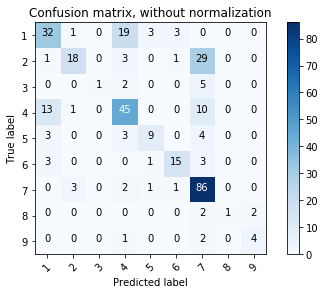

Accuracy: 0.63363


In [45]:
# Make the predictions
preds = xgb.predict(x_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, preds, labels=[1,2,3,4,5,6,7,8,9])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[1,2,3,4,5,6,7,8,9], title='Confusion matrix, without normalization')
plt.show()

# Calculate accuracy
acc = np.sum(np.diag(cm)) / np.sum(cm)
print('Accuracy: %0.5f' % acc)

In [57]:
# Make predictions for submission
preds3 = xgb.predict_proba(val_set)

submission = pd.DataFrame(preds3)
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9']
submission.to_csv("xgb_submission.csv", index=True)
submission.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,0.039697,0.061467,0.013856,0.162864,0.017777,0.628682,0.075602,0.000024,0.000031
1,0.952567,0.014096,0.001364,0.017894,0.000392,0.003283,0.010267,0.000118,0.000019
2,0.251582,0.125198,0.001980,0.060622,0.005217,0.221243,0.328679,0.005403,0.000076
3,0.118175,0.191658,0.009627,0.213447,0.017561,0.036765,0.379223,0.031326,0.002218
4,0.007979,0.116351,0.000442,0.034474,0.093419,0.009917,0.737247,0.000110,0.000060


## 7. Ensemble Predictions

In [58]:
w1 = 0.35
w2 = 0.35
w3 = 0.3

preds1 = preds1 * w1
preds2 = preds2 * w2
preds3 = preds3 * w3

preds_final = (preds1 + preds2 + preds3) / 3

submission = pd.DataFrame(preds_final)
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9']
submission.to_csv("ens_submission.csv", index=True)
submission.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,0.026475,0.008530,0.004514,0.145935,0.017000,0.121192,0.009470,0.000138,0.000080
1,0.203866,0.007381,0.001450,0.010544,0.003393,0.001268,0.104494,0.000736,0.000202
2,0.046024,0.057444,0.008123,0.038071,0.007565,0.064591,0.107175,0.002480,0.001860
3,0.032869,0.134981,0.003189,0.026434,0.003859,0.012822,0.109893,0.006049,0.003237
4,0.001445,0.141522,0.000953,0.004965,0.011360,0.002134,0.170269,0.000341,0.000344
